In [1]:
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# !pip install pmdarima
import pmdarima as pm
from pmdarima import auto_arima

tweet_vaderized = pd.read_excel('data/sentitweet610.xlsx')
reddit_vaderized = pd.read_excel('data/sentireddit610.xlsx')
startDate = pd.to_datetime('20160601')
endDate = pd.to_datetime('20161001')
i_hour = pd.date_range(start=startDate, end=endDate,freq='H')

tweet_senti = tweet_vaderized.resample('H', on='dtime').mean().reindex(i_hour).fillna(0).loc[:,['vader_compound']]
redditmidsum = reddit_vaderized.resample('H', on='time').sum().reindex(i_hour).fillna(0)
redditmidsum['sentivader'] = (redditmidsum.vaderscore / redditmidsum.scoren).fillna(0)
reddit_senti =  redditmidsum.loc[:,['sentivader']]
senti = pd.concat([tweet_senti, reddit_senti], axis=1)
senti.columns = ['tweet_senti','reddit_senti']
senti['tweet_count'] = (tweet_vaderized.resample('H', on='dtime').count().loc[:,['vader_compound']])
senti['reddit_count'] = (reddit_vaderized.resample('H', on='time').sum().loc[:,['scoren']])
senti['tweet_count'] = np.log(senti['tweet_count']+1)
senti['reddit_count'] = np.log(senti['reddit_count']+1)
senti = senti.fillna(0)

In [2]:
# from arch.unitroot import ADF,DFGLS,PhillipsPerron,KPSS
# print(ADF(senti['tweet_senti'].values))
# print(DFGLS(senti['tweet_senti'].values))
# print(PhillipsPerron(senti['tweet_senti'].values))
# print(KPSS(senti['tweet_senti'].values))

In [3]:
dates = senti.index
data = senti[['tweet_count','tweet_senti']]
data = data.fillna(0)
data.columns = ['count','senti']
data['senti'] = data['senti'].shift().fillna(0)
split_train = math.floor(len(data) * 0.2)

train = data[:-split_train]
test = data[-split_train:]

In [51]:
kalmanData = pd.concat([senti['reddit_senti'], senti['tweet_senti']],axis=1)
kalmanData.columns = ['reddit', 'tweet']

In [14]:
ar = pm.arima.ARIMA(order = (24,0,0))
ar.fit(train['senti'])

ARIMA(order=(24, 0, 0))

In [15]:
arx = pm.arima.ARIMA (order = (24,0,0))
arx.fit(train['senti'],X = pd.DataFrame(train['count']))

ARIMA(order=(24, 0, 0))

In [5]:
arma = pm.auto_arima ( train['senti'], 
                        start_p=0, start_q=0, max_p=2, max_q=2, 
                        m=24, start_P=0, start_Q=0, max_P=1, max_Q=1,   
                        seasonal=False, stationary=True, 
                        trace=True, error_action='ignore', suppress_warnings=True,                         
                        stepwise=True, scoring='mse')
# arma.summary()

/Users/jacqualync/opt/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (24) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-623.638, Time=0.76 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-976.203, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-857.664, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=485.447, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1107.322, Time=0.74 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1207.687, Time=1.96 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1200.393, Time=1.33 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1196.570, Time=1.34 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1205.463, Time=1.86 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1188.128, Time=0.76 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 9.938 seconds


In [6]:
armax = pm.auto_arima(train['senti'], X = pd.DataFrame(train['count']),
                            start_p=0, start_q=0, max_p=2, max_q=2,    
                            seasonal=False, stationary=True, 
                            trace=True, error_action='ignore', suppress_warnings=True,                         
                            stepwise=True, scoring='mse')
# armax.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-857.710, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1061.480, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1000.289, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-806.348, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1155.824, Time=0.76 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1217.171, Time=1.74 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1214.575, Time=1.21 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1210.608, Time=2.30 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1215.999, Time=2.71 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1194.536, Time=1.42 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 11.746 seconds


In [7]:
sarma = pm.auto_arima(train['senti'], 
                        start_p=0, start_q=0, max_p=2, max_q=2, 
                        m=24, start_P=0, start_Q=0, max_P=1, max_Q=1,           
                        stationary=True, seasonal=True, 
                        trace=True, error_action='ignore', suppress_warnings=True,                         
                        stepwise=True, scoring='mse')
# sarma.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-623.638, Time=0.24 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-996.453, Time=2.24 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-890.047, Time=1.88 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=485.447, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-976.203, Time=0.33 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-1011.627, Time=8.36 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-993.763, Time=1.98 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=-708.064, Time=4.84 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=-1128.927, Time=8.29 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=-1115.165, Time=2.17 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-1116.181, Time=5.41 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-1107.322, Time=0.44 sec
 ARIMA(2,0,1)(1,0,1)[24] intercept   : AIC=-1212.718, Time=9.32 sec
 ARIMA(2,0,1)(0,0,1)[24] intercept   : AIC=-1207.698, Time=7.37 sec
 ARIMA(2,0,1)

In [8]:
sarmax = pm.auto_arima(train['senti'], X = pd.DataFrame(train['count']),
                                    start_p=0, start_q=0, max_p=2, max_q=2, 
                                    m=24, start_P=0, start_Q=0, max_P=1, max_Q=1,   
                                    seasonal=True, stationary=True, 
                                    trace=True, error_action='ignore', suppress_warnings=True,                         
                                    stepwise=True, scoring='mse')                     
# sarmax.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-857.710, Time=0.45 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-1070.485, Time=4.52 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-1011.772, Time=3.38 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-806.348, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-1061.480, Time=0.36 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-1075.044, Time=5.61 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-1069.449, Time=5.54 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=-879.183, Time=2.22 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=-1166.261, Time=10.58 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=-1159.631, Time=2.83 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-1160.151, Time=3.96 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-1155.824, Time=0.85 sec
 ARIMA(2,0,1)(1,0,1)[24] intercept   : AIC=-1221.508, Time=10.64 sec
 ARIMA(2,0,1)(0,0,1)[24] intercept   : AIC=-1217.356, Time=8.51 sec
 ARIMA

In [9]:
def RMSE(pred, truth):
    return math.sqrt(mean_squared_error(truth, pred))

In [10]:
reddit_hourvar_mean = reddit_vaderized.resample('H', on='time').var().vadern.reindex(i_hour).mean() #fillna(0)
reddit_var = kalmanData['reddit'].to_numpy(dtype=float).var()
tweet_var = kalmanData['tweet'].to_numpy(dtype=float).var()
print(reddit_var,tweet_var,reddit_hourvar_mean)
H=1
R_r = reddit_hourvar_mean
predx = 72  #count可以用之前24h的平均？
datada = data[:-predx] # datada, datatp = data[:-predx], data[-predx:]
#it = range(length, len(data) - predx)

0.06726473971947694 0.048915568843057415 0.2684919913595351


In [11]:
P0_rr = reddit_var
K_r = P0_rr * H / (H * P0_rr * H + R_r)
print("K_r with Reddit as P0", K_r)
P0_rt = tweet_var
K_t = P0_rt * H / (H * P0_rt * H + R_r)
print("K_r with Twitter as P0", K_t)

K_r with Reddit as P0 0.20033772518367723
K_r with Twitter as P0 0.15410965262401422


In [12]:
def show_result(lag, da_r, pred_r): 
    ### VALIDATION ###
    plt.figure(figsize=(5, 3))
    # 1) see if residuals are zero mean gaussian (MAKE SURE TO SET DELAY TO ZERO!)
    res = kalmanData[pred_r][lag:-predx] - kalmanData['reddit'][lag:-predx].to_numpy()  # all Reddits
    (mu, sigma) = norm.fit(res)
    # the residual error plot (histogram + normal distr)
    n, bins, patches = plt.hist(res, density=True, facecolor='C0', alpha=0.75)
    y = norm.pdf(bins, loc=mu, scale=sigma)
    plt.plot(bins, y, 'r--', linewidth=2)
    plt.title("Wildfire Sentiment with $\mu=" + str(round(mu, 4)) + "$ and $\sigma =" + str(round(sigma, 4)) + "$")
    plt.show()
    # 2) MSE
    mse_t = RMSE(kalmanData[da_r][lag:-predx], kalmanData['tweet'][lag:-predx])**2   
    mse_r = RMSE(kalmanData[da_r][lag:-predx], kalmanData['reddit'][lag:-predx])**2 #sum((X - Y_reddit) ** 2) / X.size
    print("mse for tweet / reddit ", mse_t, mse_r)

In [40]:
def plot_result(paras, part):    
    #part = 0
    plt.figure(figsize=(16,8)) 
    plt.plot(kalmanData['tweet'][-part:], linestyle='-', label='Tweets', alpha=0.7)
    plt.plot(kalmanData['reddit'][-part:], linestyle='-', label='Reddits', alpha=0.7) 
    for para in paras:
        plt.plot(kalmanData[para][-part:], linestyle='--', label='Assimilated '+para) 
    plt.fill_between(dates[-predx:], -1, 1,facecolor='gainsboro', interpolate=True)
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score")
    plt.legend()
    plt.ylim([-1, 1])
    plt.show()

#plot_result(['da_oi_orr','da_oi_seasonr','da_oi_countr','da_oi_seacountr'], part=144)

In [16]:
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef) + 1):
        yhat += coef[i - 1] * history[-i]
    return yhat

# EnKF

In [17]:
Q_r = R_r
n_points = 1000

In [50]:
def Enkf_arima(Q_r, R_r, mod, mod_name, count, da_r, pred_r, k_r):
    P0_r = reddit_var
    kalmanData[da_r], kalmanData[pred_r], kalmanData[k_r]= np.nan, np.nan, np.nan 
    
    if count == 0: mod.fit(datada['senti'])
    else: mod.fit(datada['senti'],X=pd.DataFrame(datada['count']))       
    resid = mod.resid()
    
    if mod_name == 'ar' or mod_name == 'arx' : lag = 24
    if mod_name == 'arma' or mod_name == 'armax' : lag = 2
    if mod_name == 'sarma' or mod_name == 'sarmax': lag = 26
    
    if mod_name == 'ar': intercept, ar_coef = mod.params()[0], mod.arparams()  
    if mod_name == 'arx': intercept, count, ar_coef = mod.params()[0],mod.params()[1], mod.arparams()
    if mod_name == 'arma': intercept,ar1,ar2,ma1,_ = mod.params()
    if mod_name == 'sarma': intercept,ar1,ar2,ma1,ar24,ma24,_ = mod.params()
    if mod_name == 'armax': intercept,count,ar1,ar2,ma1,_ = mod.params()
    if mod_name == 'sarmax': intercept,count,ar1,ar2,ma1,ar24,ma24,_ = mod.params()
    
    seq = np.reshape(datada['senti'][:lag].values,(lag,1))
    sigmas_seq = np.empty((n_points, lag, 1))    
    sigmas = np.random.normal(0, P0_r, size=(n_points, 1))  # draw from distribution, normally P0_r
    for i in range(n_points):
        sigmas_seq[i] = seq + sigmas[i]
#     Ks = []
    xf = np.empty([n_points, 1])  
    
    # assimilation scheme
    q = 0
    for j in range(lag, len(datada)): 
        # predict
        for i in range(n_points):
            if mod_name == 'ar':xf[i] = intercept + predict(ar_coef, sigmas_seq[i]) 
            if mod_name == 'arx':xf[i] = count*datada['count'][j]+ intercept + predict(ar_coef, sigmas_seq[i]) 
            if mod_name == 'arma':xf[i] = intercept+ar1*sigmas_seq[i][-1]+ar2*sigmas_seq[i][-2]+resid[j]+ma1*resid[j-1] 
            if mod_name == 'sarma':xf[i] = intercept+ar1*sigmas_seq[i][-1]+ar2*sigmas_seq[i][-2]+ar24*(sigmas_seq[i][-24]-ar1*sigmas_seq[i][-25]-ar2*sigmas_seq[i][-26])+resid[j]+ma1*resid[j-1]+ma24*(resid[j-24]+ma1*resid[j-25])
            if mod_name == 'armax':xf[i] = count*datada['count'][j]+intercept+ar1*sigmas_seq[i][-1]+ar2*sigmas_seq[i][-2]+resid[j]+ma1*resid[j-1]  
            if mod_name == 'sarmax':xf[i]=count*datada['count'][j]+intercept+ar1*sigmas_seq[i][-1]+ar2*sigmas_seq[i][-2]+ar24*(sigmas_seq[i][-24]-ar1*sigmas_seq[i][-25]-ar2*sigmas_seq[i][-26])+resid[j]+ma1*resid[j-1]+ma24*(resid[j-24]+ma1*resid[j-25])          
            
        xf += np.random.normal(0, Q_r, size=(n_points, 1))  # should be x and p0?
        xmean = np.mean(xf)     
        kalmanData[pred_r].iloc[j] = xmean 
        # update
        xf_z = H * xf
        zmean = np.mean(xf_z)
        Pzz = np.var(xf_z, ddof=1) + R_r
        Pxz = 0
        for i in range(n_points):
            Pxz += (xf[i] - xmean) * (xf_z[i] - zmean)
        Pxz /= n_points - 1
        K_r = Pxz / Pzz
#         Ks.append(K_r)
        kalmanData[k_r].iloc[j] = K_r 
        v_r = np.random.normal(0, R_r, n_points) 
        for i in range(n_points):
            xf[i] += K_r * (kalmanData['reddit'].iloc[j] + v_r[i] - xf_z[i])
        x0 = np.mean(xf)
        P0_r = P0_r - K_r * Pzz * K_r
        kalmanData[da_r].iloc[j] = x0
        # create new sequence
        for i in range(n_points):
            if count == 0: seq = np.append(sigmas_seq[i], xf[i])
            else: seq = np.append(sigmas_seq[i], xf[i]-count*data['count'][j])
            sigmas_seq[i] = np.reshape(seq[1:],(lag,1))
        q += 1      
        
    # predict x hours ahead   
    for j in range(len(datada), len(data)):
        for i in range(n_points):
            if mod_name == 'ar': xf[i] = intercept + predict(ar_coef, sigmas_seq[i]) 
            if mod_name == 'arx': xf[i] = count*data['count'][j]+intercept + predict(ar_coef, sigmas_seq[i]) 
            if mod_name == 'arma': xf[i] = intercept+ar1*sigmas_seq[i][-1]+ar2*sigmas_seq[i][-2]
            if mod_name == 'sarma': xf[i] = intercept+ar1*sigmas_seq[i][-1]+ar2*sigmas_seq[i][-2]+ar24*(sigmas_seq[i][-24]-ar1*sigmas_seq[i][-25]-ar2*sigmas_seq[i][-26])
            if mod_name == 'armax': xf[i] = count*data['count'][j]+intercept+ar1*sigmas_seq[i][-1]+ar2*sigmas_seq[i][-2]
            if mod_name == 'sarmax': xf[i]=count*data['count'][j]+intercept+ar1*sigmas_seq[i][-1]+ar2*sigmas_seq[i][-2]+ar24*(sigmas_seq[i][-24]-ar1*sigmas_seq[i][-25]-ar2*sigmas_seq[i][-26])               
        q += 1
        xf += np.random.normal(0, Q_r, size=(n_points, 1))  # should be x and p0?
        xmean = np.mean(xf)
        kalmanData[pred_r].iloc[j], kalmanData[da_r].iloc[j] = xmean, xmean  #preds_extra_tweet.append(xmean)
        for i in range(n_points):
            if count == 0: seq = np.append(sigmas_seq[i], xf[i])
            else: seq = np.append(sigmas_seq[i], xf[i]-count*data['count'][j])
            sigmas_seq[i] = np.reshape(seq[1:], (lag, 1))
    
    show_result(lag, da_r, pred_r)    

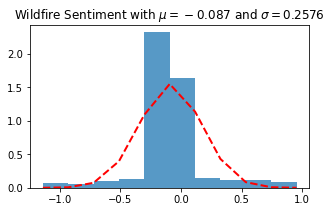

mse for tweet / reddit  0.05742139193293677 0.04408305405276274


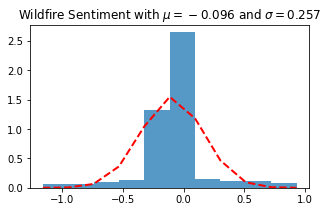

mse for tweet / reddit  0.055209943135028874 0.04504331753582412


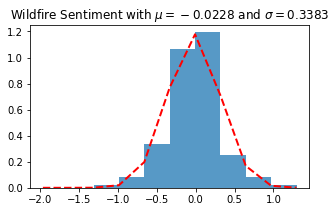

mse for tweet / reddit  0.08810996082141839 0.05066121760963788


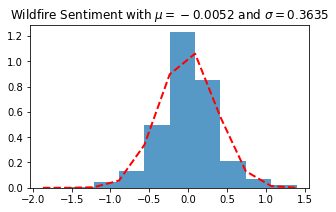

mse for tweet / reddit  0.09867251681083257 0.05016195356989316


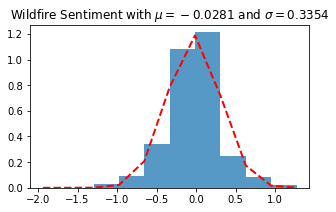

mse for tweet / reddit  0.08620280556665606 0.050943280124743306


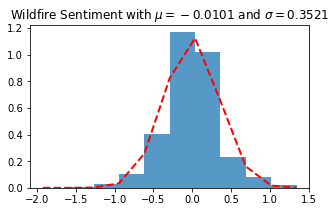

mse for tweet / reddit  0.09467372736524098 0.05021956961899347


In [52]:
Enkf_arima(Q_r, R_r, ar, 'ar', 0, 'da_ekf_ar', 'pred_ekf_ar','k_ar')
Enkf_arima(Q_r, R_r, arx, 'arx', 1, 'da_ekf_arx', 'pred_ekf_arx','k_arx')
Enkf_arima(Q_r, R_r, arma, 'arma', 0, 'da_ekf_arma', 'pred_ekf_arma','k_arma')
Enkf_arima(Q_r, R_r, sarma, 'sarma', 0, 'da_ekf_sarma', 'pred_ekf_sarma','k_sarma')
Enkf_arima(Q_r, R_r, armax, 'armax', 1, 'da_ekf_armax', 'pred_ekf_armax','k_armax')
Enkf_arima(Q_r, R_r, sarmax, 'sarmax', 1, 'da_ekf_sarmax', 'pred_ekf_sarmax','k_sarmax')

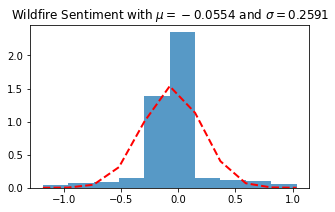

mse for tweet / reddit  0.08000119419617906 0.015761769122399114


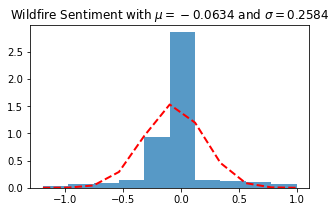

mse for tweet / reddit  0.07844568241022709 0.015983253002036513


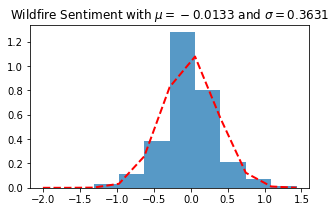

mse for tweet / reddit  0.09916152035780655 0.023069981694671685


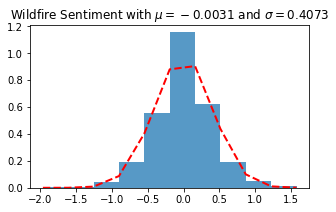

mse for tweet / reddit  0.10690260387732985 0.024593593761741802


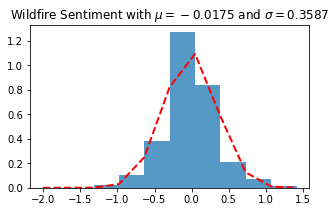

mse for tweet / reddit  0.0977970811761042 0.02279712680384894


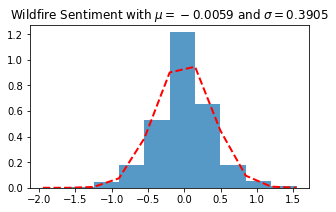

mse for tweet / reddit  0.10402870193721855 0.024046369133030758


In [54]:
Enkf_arima(2*R_r, R_r, ar, 'ar', 0, 'da_ekf_ar1', 'pred_ekf_ar1','k_ar1')
Enkf_arima(2*R_r, R_r, arx, 'arx', 1, 'da_ekf_arx1', 'pred_ekf_arx1','k_arx1')
Enkf_arima(2*R_r, R_r, arma, 'arma', 0, 'da_ekf_arma1', 'pred_ekf_arma1','k_arma1')
Enkf_arima(2*R_r, R_r, sarma, 'sarma', 0, 'da_ekf_sarma1', 'pred_ekf_sarma1','k_sarma1')
Enkf_arima(2*R_r, R_r, armax, 'armax', 1, 'da_ekf_armax1', 'pred_ekf_armax1','k_armax1')
Enkf_arima(2*R_r, R_r, sarmax, 'sarmax', 1, 'da_ekf_sarmax1', 'pred_ekf_sarmax1','k_sarmax1')

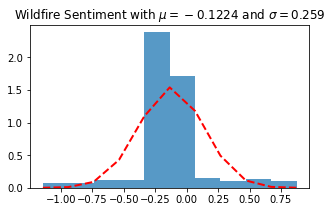

mse for tweet / reddit  0.049744366638115656 0.07040440914970582


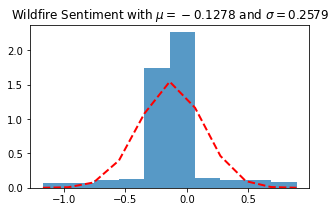

mse for tweet / reddit  0.04777889409596351 0.07136134600881308


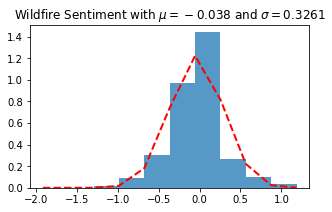

mse for tweet / reddit  0.08088560927508287 0.07431980545291693


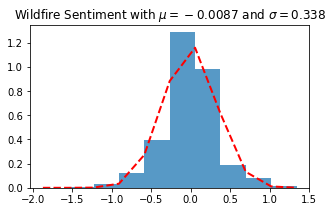

mse for tweet / reddit  0.0928813606649453 0.07148075027646654


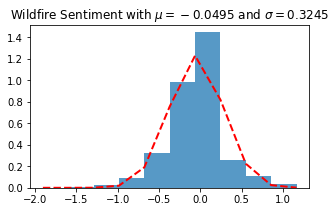

mse for tweet / reddit  0.07744156143949409 0.0757522107964072


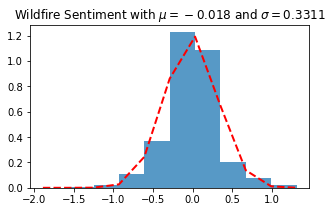

mse for tweet / reddit  0.08805387750810537 0.07228732149768503


In [55]:
Enkf_arima(0.5*R_r, R_r, ar, 'ar', 0, 'da_ekf_ar2', 'pred_ekf_ar2', 'k_ar2')
Enkf_arima(0.5*R_r, R_r, arx, 'arx', 1, 'da_ekf_arx2', 'pred_ekf_arx2', 'k_arx2')
Enkf_arima(0.5*R_r, R_r, arma, 'arma', 0, 'da_ekf_arma2', 'pred_ekf_arma2', 'k_arma2')
Enkf_arima(0.5*R_r, R_r, sarma, 'sarma', 0, 'da_ekf_sarma2', 'pred_ekf_sarma2', 'k_sarma2')
Enkf_arima(0.5*R_r, R_r, armax, 'armax', 1, 'da_ekf_armax2', 'pred_ekf_armax2', 'k_armax2')
Enkf_arima(0.5*R_r, R_r, sarmax, 'sarmax', 1, 'da_ekf_sarmax2', 'pred_ekf_sarmax2', 'k_sarmax2')

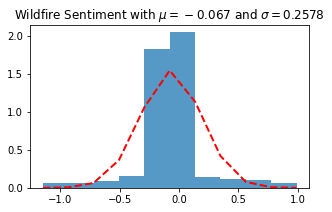

mse for tweet / reddit  0.06734686589128981 0.028679296893766224


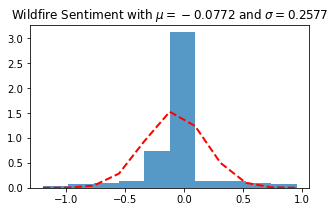

mse for tweet / reddit  0.06527970007183086 0.029385950450795652


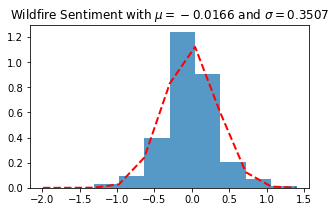

mse for tweet / reddit  0.09379315667573052 0.03466551235697102


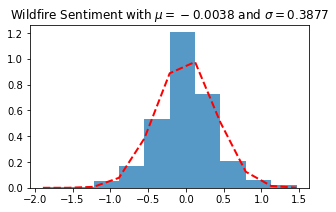

mse for tweet / reddit  0.10386113271226945 0.03369683734586363


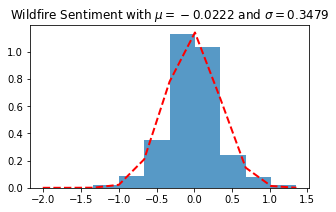

mse for tweet / reddit  0.0919962184814944 0.0350017880286709


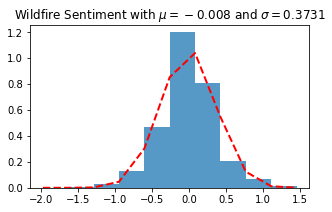

mse for tweet / reddit  0.10000708054541364 0.0342395635416893


In [56]:
Enkf_arima(2*R_r, 2*R_r, ar, 'ar', 0, 'da_ekf_ar3', 'pred_ekf_ar3', 'k_ar3')
Enkf_arima(2*R_r, 2*R_r, arx, 'arx', 1, 'da_ekf_arx3', 'pred_ekf_arx3', 'k_arx3')
Enkf_arima(2*R_r, 2*R_r, arma, 'arma', 0, 'da_ekf_arma3', 'pred_ekf_arma3', 'k_arma3')
Enkf_arima(2*R_r, 2*R_r, sarma, 'sarma', 0, 'da_ekf_sarma3', 'pred_ekf_sarma3', 'k_sarma3')
Enkf_arima(2*R_r, 2*R_r, armax, 'armax', 1, 'da_ekf_armax3', 'pred_ekf_armax3', 'k_armax3')
Enkf_arima(2*R_r, 2*R_r, sarmax, 'sarmax', 1, 'da_ekf_sarmax3', 'pred_ekf_sarmax3', 'k_sarmax3')

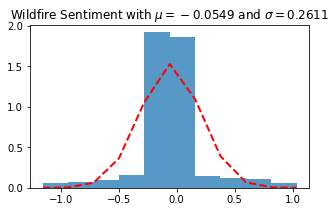

mse for tweet / reddit  0.08099726526340652 0.01603424956455462


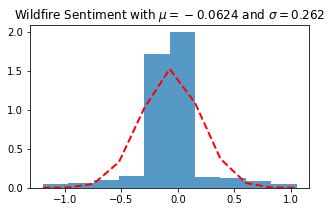

mse for tweet / reddit  0.07973895590125184 0.016238943738613034


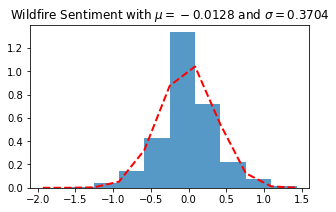

mse for tweet / reddit  0.10205238696715387 0.01908876244148088


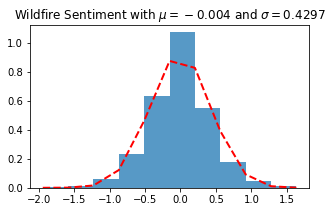

mse for tweet / reddit  0.11040153791810331 0.017896081848533415


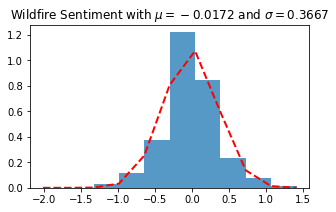

mse for tweet / reddit  0.10075285432889407 0.019537474285986


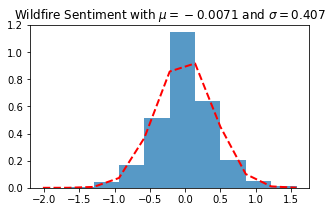

mse for tweet / reddit  0.10805838134067741 0.017887304956406107


In [86]:
Enkf_arima(4*R_r, 4*R_r, ar, 'ar', 0, 'da_ekf_ar4', 'pred_ekf_ar4', 'k_ar4')
Enkf_arima(4*R_r, 4*R_r, arx, 'arx', 1, 'da_ekf_arx4', 'pred_ekf_arx4', 'k_arx4')
Enkf_arima(4*R_r, 4*R_r, arma, 'arma', 0, 'da_ekf_arma4', 'pred_ekf_arma4', 'k_arma4')
Enkf_arima(4*R_r, 4*R_r, sarma, 'sarma', 0, 'da_ekf_sarma4', 'pred_ekf_sarma4', 'k_sarma4')
Enkf_arima(4*R_r, 4*R_r, armax, 'armax', 1, 'da_ekf_armax4', 'pred_ekf_armax4', 'k_armax4')
Enkf_arima(4*R_r, 4*R_r, sarmax, 'sarmax', 1, 'da_ekf_sarmax4', 'pred_ekf_sarmax4', 'k_sarmax4')

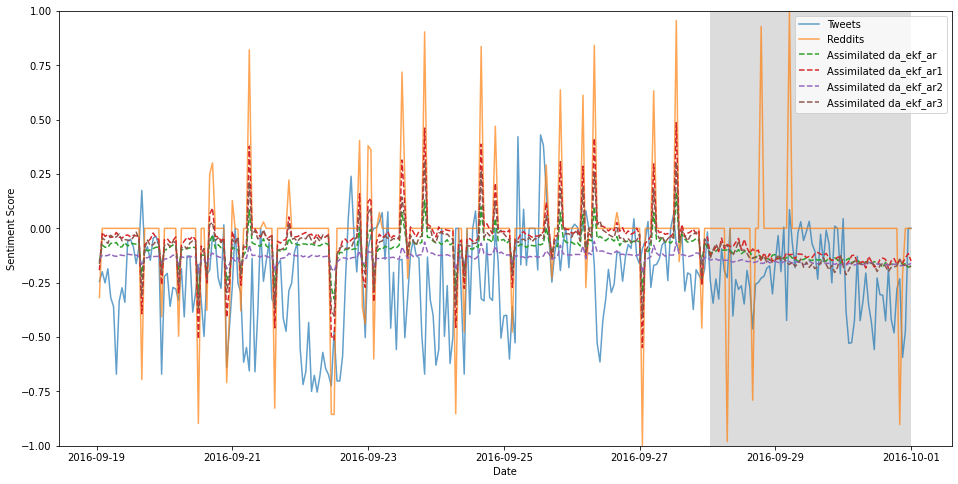

In [58]:
plot_result(['da_ekf_ar', 'da_ekf_ar1','da_ekf_ar2','da_ekf_ar3'], 288)

(0.22865416271712685,
 0.2261949507963263,
 0.3363005565214601,
 0.38316994317354075,
 0.3297172769197103,
 0.36385038306047485)

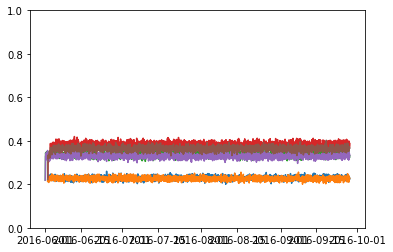

In [82]:
plt.plot(kalmanData['k_ar'])
plt.plot(kalmanData['k_arx'])
plt.plot(kalmanData['k_arma'])
plt.plot(kalmanData['k_sarma'])
plt.plot(kalmanData['k_armax'])
plt.plot(kalmanData['k_sarmax'])
plt.ylim([0,1])
kalmanData['k_ar'].mean(),kalmanData['k_arx'].mean(),kalmanData['k_arma'].mean(),kalmanData['k_sarma'].mean(),kalmanData['k_armax'].mean(),kalmanData['k_sarmax'].mean()

(0.5262797896654033,
 0.52518208066892,
 0.5821645885328622,
 0.6147538146315459,
 0.579349976747262,
 0.6036103595358798)

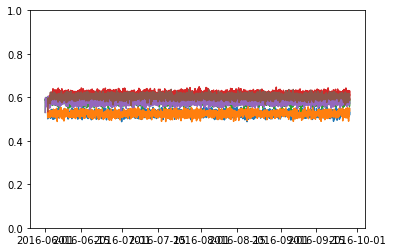

In [83]:
plt.plot(kalmanData['k_ar1'])
plt.plot(kalmanData['k_arx1'])
plt.plot(kalmanData['k_arma1'])
plt.plot(kalmanData['k_sarma1'])
plt.plot(kalmanData['k_armax1'])
plt.plot(kalmanData['k_sarmax1'])
plt.ylim([0,1])
kalmanData['k_ar1'].mean(),kalmanData['k_arx1'].mean(),kalmanData['k_arma1'].mean(),kalmanData['k_sarma1'].mean(),kalmanData['k_armax1'].mean(),kalmanData['k_sarmax1'].mean()

(0.07376878807040992,
 0.07210512038066567,
 0.1691934885257634,
 0.20910823785555566,
 0.16143381073354066,
 0.18927679591461147)

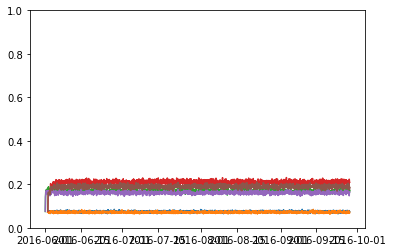

In [84]:
plt.plot(kalmanData['k_ar2'])
plt.plot(kalmanData['k_arx2'])
plt.plot(kalmanData['k_arma2'])
plt.plot(kalmanData['k_sarma2'])
plt.plot(kalmanData['k_armax2'])
plt.plot(kalmanData['k_sarmax2'])
plt.ylim([0,1])
kalmanData['k_ar2'].mean(),kalmanData['k_arx2'].mean(),kalmanData['k_arma2'].mean(),kalmanData['k_sarma2'].mean(),kalmanData['k_armax2'].mean(),kalmanData['k_sarmax2'].mean()

(0.3656626485979178,
 0.36375530321377375,
 0.4701432691093444,
 0.525977208422874,
 0.4639396242305933,
 0.5043757999985039)

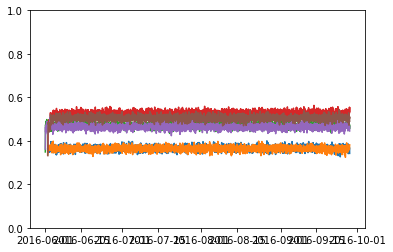

In [88]:
plt.plot(kalmanData['k_ar3'])
plt.plot(kalmanData['k_arx3'])
plt.plot(kalmanData['k_arma3'])
plt.plot(kalmanData['k_sarma3'])
plt.plot(kalmanData['k_armax3'])
plt.plot(kalmanData['k_sarmax3'])
plt.ylim([0,1])
kalmanData['k_ar3'].mean(),kalmanData['k_arx3'].mean(),kalmanData['k_arma3'].mean(),kalmanData['k_sarma3'].mean(),kalmanData['k_armax3'].mean(),kalmanData['k_sarmax3'].mean()

(0.531693099088688,
 0.5308140605151243,
 0.6314391154344536,
 0.6960065914473055,
 0.6257225685451986,
 0.6742761747737372)

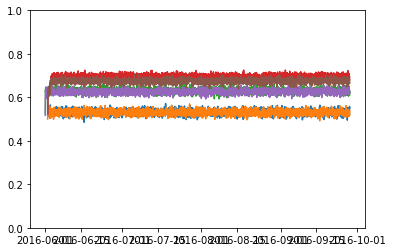

In [89]:
plt.plot(kalmanData['k_ar4'])
plt.plot(kalmanData['k_arx4'])
plt.plot(kalmanData['k_arma4'])
plt.plot(kalmanData['k_sarma4'])
plt.plot(kalmanData['k_armax4'])
plt.plot(kalmanData['k_sarmax4'])
plt.ylim([0,1])
kalmanData['k_ar4'].mean(),kalmanData['k_arx4'].mean(),kalmanData['k_arma4'].mean(),kalmanData['k_sarma4'].mean(),kalmanData['k_armax4'].mean(),kalmanData['k_sarmax4'].mean()


In [87]:
kalmanData.to_excel('sarimaekf.xlsx', index=True)